<h1>Battle of Neighborhoods with two Universities in Toronto</h1>

<h3>Import libraries</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
! pip install folium==0.5.0
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound
import requests
from sklearn.preprocessing import MinMaxScaler
import os
import json
from sklearn.cluster import KMeans
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup as bs
import requests

<h3>Prepare Data For Tornoto City</h3>

In [2]:
# getting data
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_data= requests.get(url).text
#parse HTML codes
soup_data = bs(raw_data, 'html.parser')
#print(soup_data.prettify())
header = soup_data.find_all("table")[0].find("tr")
print(header)

<tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>


In [3]:
data = []
list_header = []
for items in header:
    try:
        sub_item = items.get_text()
        list_header.append(sub_item.rstrip())
    except:
        continue
HTML_data = soup_data.find_all("table")[0].find_all("tr")[1:]
#print(HTML_data)
for element in HTML_data:
    sub_data = []
    for sub_element in element:
        try:
            sub_sub_element = sub_element.get_text()
            sub_data.append(sub_sub_element.rstrip())
        except:
            continue
    data.append(sub_data)
#convert to dataframe
df = pd.DataFrame(list(data), columns = list_header)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Cleaning Data
df = df[df.Borough != 'Not assigned']
not_assigned_nei = df['Neighbourhood'] == 'Not assigned'
df['Neighbourhood'][not_assigned_nei] = df['Borough'][not_assigned_nei]
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
#Merge rows that with same postal code
df.to_dict('series')
foo = lambda a: ", ".join(a) 
df2 = df.groupby(by = 'Postal Code').agg({'Borough':'first','Neighbourhood':foo}).reset_index()
df2.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
df2.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
df2

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [6]:
df.to_dict('series')
foo = lambda a: ", ".join(a) 
df2 = df.groupby(by = 'Postal Code').agg({'Borough':'first','Neighbourhood':foo}).reset_index()
df2.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
df2.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo.rename(columns ={"Postal Code":"PostalCode"}, inplace = True)
df3 = df2.merge(df_geo)
df3

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


In [7]:
#df3.to_dict('series')
#df4 = df3.groupby(by = 'Borough').agg({'PostalCode':foo,'Neighborhood':foo, 'Latitude':['min','max'], 'Longitude':['min','max']}).reset_index()
#df4

In [8]:
CLIENT_ID = 'ZATDKOURVOB4AJ3IIXSUAGCRRHDXZEA3EQLVZ4JZKLTAC53F' # your Foursquare ID
CLIENT_SECRET = 'I23YRMSDJN2POURVLYUA4FQ3YPS5MB33ZJACN4BGSZLFRFMC' # your Foursquare Secret
ACCESS_TOKEN = '2FENZ0FVTWEG2MSPQJD5X15JOMEIH1XG321FZ4OKA05HKKIO' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZATDKOURVOB4AJ3IIXSUAGCRRHDXZEA3EQLVZ4JZKLTAC53F
CLIENT_SECRET:I23YRMSDJN2POURVLYUA4FQ3YPS5MB33ZJACN4BGSZLFRFMC


In [9]:
address = 'University of Toronto'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude_uoT = location.latitude
longitude_uoT = location.longitude
postcode_uoT = location.address
print(latitude_uoT, longitude_uoT, postcode_uoT)

43.663461999999996 -79.39775965337452 University of Toronto, Wellesley-Hoskin Cycle Track, Bloor Street Culture Corridor, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5S 1C4, Canada


In [10]:
address = 'York University'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude_vu = location.latitude
longitude_vu = location.longitude
postcode_vu = location.address
print(latitude_vu, longitude_vu, postcode_vu)

43.7743325 -79.50027054016516 York University, 120, Ian Macdonald Boulevard, Humber River—Black Creek, North York, Toronto, Golden Horseshoe, Ontario, M7A 2C5, Canada


In [11]:
a = ['M5S','M7A']
df5 = df3[df3['PostalCode'].isin(a)].reset_index()
df5

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,66,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049
1,85,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [12]:
address = 'Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6534817 -79.3839347


In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for borough, neighborhood, lat, lng in zip(df5['Borough'], df5['Neighborhood'],df5['Latitude'], df5['Longitude']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [14]:

categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION )
            
results = requests.get(categories_url).json()

print(results)

categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

{'meta': {'code': 200, 'requestId': '601783c3b1ab5d0126938280'}, 'response': {'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 'pluralName': 'Arcades', 'shortName': 'Arcade', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/a

In [15]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION, lat, long, categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [16]:
df6 = df5.copy()
for c in categories_list:
    df6[c[0]] = 0

df6.head()

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,66,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,0,0,0,0,0,0,0,0,0,0
1,85,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,0,0,0,0,0


In [17]:
for i, row in df6.iterrows():
    for c in categories_list:        
        df6.loc[i, c[0]] = get_venues_count(df6.iloc[i].Latitude,  df6.iloc[i].Longitude, radius=500, categoryId=c[1])
df6      

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,66,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,31,107,7,119,53,40,140,69,98,51
1,85,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,27,109,6,81,24,52,144,69,103,58


In [18]:
df6 = df6.drop(['index','Neighborhood','PostalCode','Borough','Latitude','Longitude'], axis = 1)
university = ['University of Toronto','York University']
df6['University'] = university
df6

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,University
0,31,107,7,119,53,40,140,69,98,51,University of Toronto
1,27,109,6,81,24,52,144,69,103,58,York University


Text(0, 0.5, 'Venues')

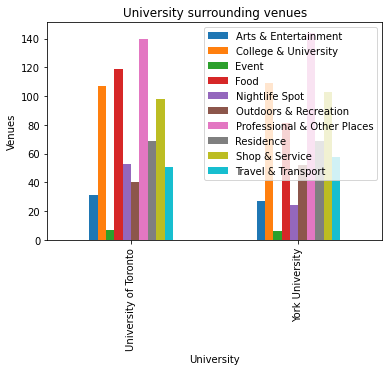

In [19]:
df6.plot(kind='bar',x='University')
plt.title("University surrounding venues")
plt.xlabel("University")
plt.ylabel("Venues")

In [20]:
df6_transposed = df6.T
df6_transposed

,0,1
Arts & Entertainment,31,27
College & University,107,109
Event,7,6
Food,119,81
Nightlife Spot,53,24
Outdoors & Recreation,40,52
Professional & Other Places,140,144
Residence,69,69
Shop & Service,98,103
Travel & Transport,51,58


In [24]:
df6_transposed.columns = df6_transposed.iloc[10]
df6_transposed=df6_transposed[:-1]
df6_transposed

University,University of Toronto,York University
Arts & Entertainment,31,27
College & University,107,109
Event,7,6
Food,119,81
Nightlife Spot,53,24
Outdoors & Recreation,40,52
Professional & Other Places,140,144
Residence,69,69
Shop & Service,98,103
Travel & Transport,51,58


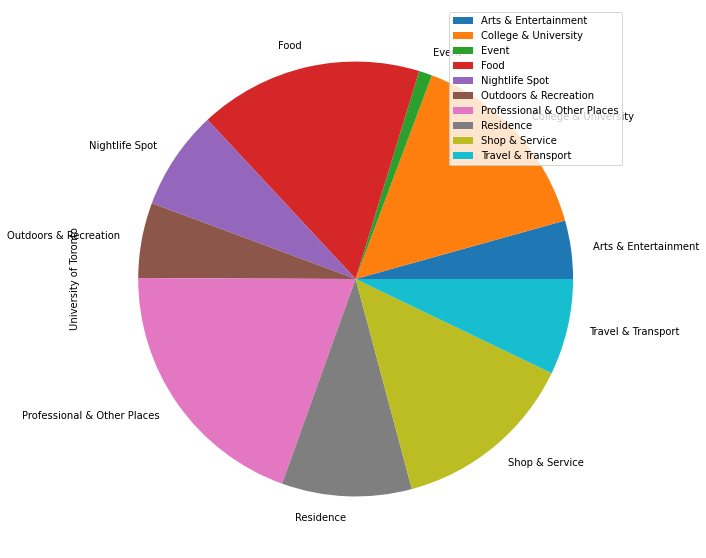

In [26]:
plot = df6_transposed.plot.pie(y='University of Toronto', figsize=(10, 10))

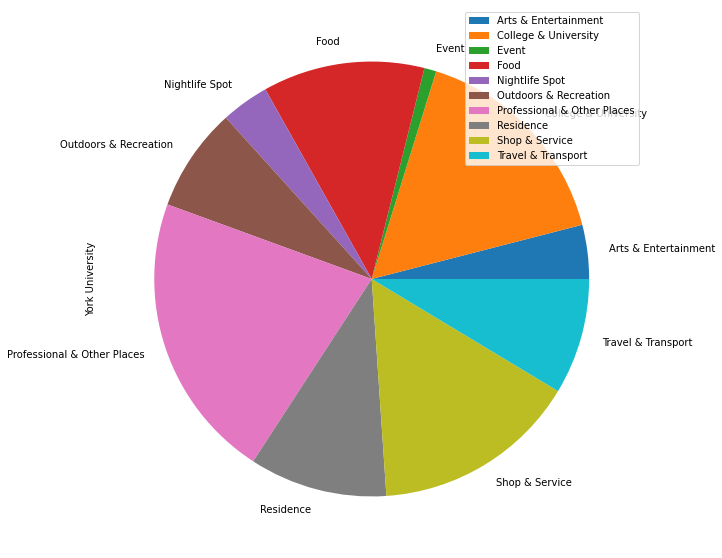

In [27]:
plot = df6_transposed.plot.pie(y='York University', figsize=(10, 10))